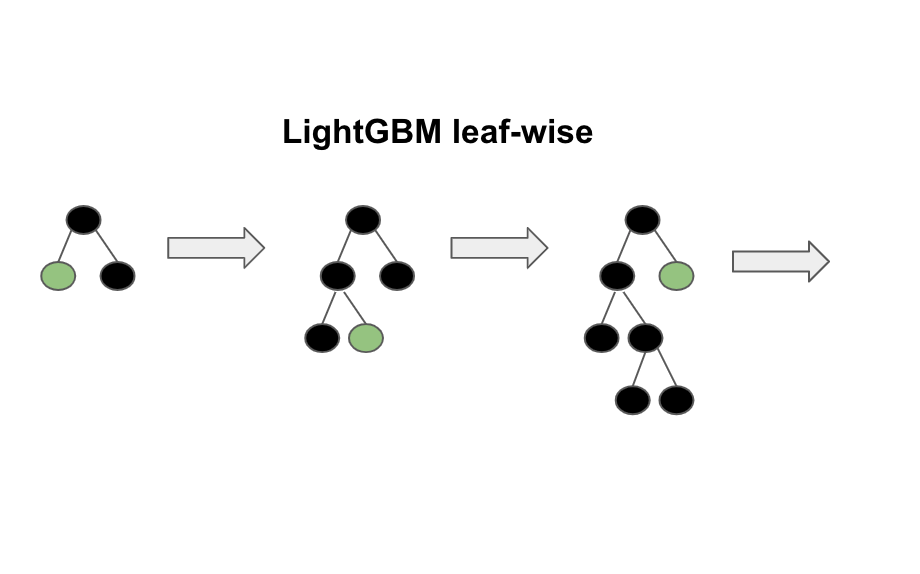

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.

- Lower memory usage.

- Better accuracy.

- Support of parallel, distributed, and GPU learning.

- Capable of handling large-scale data.

For more details, please refer to [LightGBM’s documentation!](https://lightgbm.readthedocs.io/en/latest/)

## The Previous Notebook : <br>
### [Questions and answers📝EDA to Forecasting](https://www.kaggle.com/yassershrief/questions-and-answers-eda-to-forecasting/edit)<br>
## The RNN-LSTM Model  : <br>
### [Stock-LSTM-Deep Learning](https://www.kaggle.com/yassershrief/crypo-lstm-2022-actual-price-91-acc/edit)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt
import random
from lightgbm import LGBMRegressor
import gresearch_crypto
import traceback
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

**Datatable** (heavily inspired by R's data.table) can read large datasets fairly quickly and is often faster than pandas. It is specifically meant for data processing of tabular datasets with emphasis on speed and support for large sized data. 👌

In [ ]:
df = dt.fread('../input/g-research-crypto-forecasting/train.csv').to_pandas()
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.set_index('datetime').drop('timestamp', axis=1)

df.head()

In [ ]:
df_asset_details = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv').sort_values("Asset_ID")
df_asset_details

# preprocessing

## Split data
Traning data before `13-06-2021` and validation data from `14-06-2021` to the end<br>
Kindly refer to the [topic](https://www.kaggle.com/c/g-research-crypto-forecasting/discussion/285505)

In [ ]:
df_train = df[(df.index< '2021-06-13 00:00:00')]
df_val = df[(df.index > '2021-06-13 00:00:00')]
display(df_train.tail(1))
display(df_val.head(1))

### features Engineering

In [ ]:
def get_features(df):

    df['upper_shadow'] = df['High'] / df[['Close', 'Open']].max(axis=1)
    df['lower_shadow'] = df[['Close', 'Open']].min(axis=1) / df['Low']
    df['open2close'] = df['Close'] / df['Open']
    df['high2low'] = df['High'] / df['Low']
    mean_price = df[['Open', 'High', 'Low', 'Close']].mean(axis=1)
    median_price = df[['Open', 'High', 'Low', 'Close']].median(axis=1)
    df['high2mean'] = df['High'] / mean_price
    df['low2mean'] = df['Low'] / mean_price
    df['high2median'] = df['High'] / median_price
    df['low2median'] = df['Low'] / median_price
    df['volume2count'] = df['Volume'] / (df['Count'] + 1)
    return df   

In [ ]:
def get_Xy_and_model_for_asset(df_train, asset_id):
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    df_proc = get_features(df)
    df_proc['y'] = df['Target']
    df_proc = df_proc.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
    X = df_proc.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',"y",'Target'], axis=1)
    y = df_proc["y"]

    model = LGBMRegressor( 
                          n_estimators = 800, 
                          learning_rate = 0.01, 
                          max_bin = 15, 
                          num_leaves = 100
                        
                          )
    model.fit(X, y)
    return X, y, model

# Models Traning

There are two ways to try out:<br>
- 1- modelling each asset separately
- 2- the multiple asset LGBM model


## 1- Loop over all assets

In [ ]:
Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y, model = get_Xy_and_model_for_asset(df_train, asset_id)    
    Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model
print("Models training finished")

# Evaluate all models on the validation set:

In [ ]:
def Evaluate(ID):   
    
    crypto_model=models[ID]
    df_all = get_features(df_val)
    df_crypto=df_all[df_all['Asset_ID']==ID]
    
    df_crypto['y'] = df_crypto['Target']
    df_crypto = df_crypto.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
    X_crypto = df_crypto.drop(['y','Target','Open', 'High', 'Low', 'Close', 'Volume', 'VWAP'], axis=1)
    y_crypto = df_crypto["y"]

    print(f'MAE Of model : {mean_absolute_error(y_crypto, crypto_model.predict(X_crypto)):.6f}')
    print(f'MSE Of model : {mean_squared_error(y_crypto, crypto_model.predict(X_crypto)):.6f}')
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"The mean and abs squared errorfor {asset_name:<16} (ID={asset_id:<2})")
    Evaluate(asset_id)
    print('-'*40)
print('*'*15,'The evaluation done','*'*15)    

### 2-Full Model

In [ ]:
df = df_train.copy()
    
df_all = get_features(df)
df_all['y'] = df['Target']
df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
X = df_all.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',"y",'Target'], axis=1)
y = df_all["y"]

In [ ]:
model = LGBMRegressor( 
                        n_estimators = 100, 
                          learning_rate = 0.01, 
                            max_bin = 15, 
                              num_leaves = 100
                          )
model.fit(X, y)

## Evaluate:

In [ ]:
df_all = get_features(df_val)
    
df_all['y'] = df_all['Target']
df_all = df_all.replace([np.inf, -np.inf], np.nan).dropna(how="any")
    
X_crypto = df_all.drop(['y','Target','Open', 'High', 'Low', 'Close', 'Volume', 'VWAP'], axis=1)
y_crypto = df_all["y"]

print(f'MAE Of model : {mean_absolute_error(y_crypto, model.predict(X_crypto)):.6f}')
print(f'MSE Of model : {mean_squared_error(y_crypto, model.predict(X_crypto)):.6f}')
print('*'*15,'The evaluation done','*'*15) 

In [ ]:
# feature importance
fi_df = pd.DataFrame()
fi_df['features'] = X_crypto.columns
fi_df['importance'] = model.booster_.feature_importance(importance_type="gain")

In [ ]:
# plot feature importance
fig, ax = plt.subplots(1, 1, figsize=(7, 15))
sns.barplot(
    x='importance'
    , y='features'
    , data=fi_df.sort_values(by=['importance'], ascending=False)
    , ax=ax
)

# Predict & submit

In [ ]:
# #**********For submit sepretly models for each asset*************
# env = gresearch_crypto.make_env()
# iter_test = env.iter_test()

# for i, (df_test, df_pred) in enumerate(iter_test):
#     for j , row in df_test.iterrows():
        
#         model = models[row['Asset_ID']]
#         x_test = get_features(row)
#         y_pred = model.predict([x_test])[0]
        
#         df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
        
        
#         # Print just one sample row to get a feeling of what it looks like
#         if i == 0 and j == 0:
#             display(x_test)

#     # Display the first prediction dataframe
#     if i == 0:
#         display(df_pred)

#     # Send submissions
#     env.predict(df_pred)

**Submit the full model.**

In [ ]:
features = ['Asset_ID', 'Count', 'upper_shadow', 'lower_shadow', 'open2close', 'high2low', 'high2mean', 'low2mean', 'high2median', 'low2median', 'volume2count']

In [ ]:
import gresearch_crypto
env = gresearch_crypto.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (test_df, sample_prediction_df) in iter_test:
    # feature engineering
    test_df = get_features(test_df)
    
    # inference
    sample_prediction_df['Target'] = model.predict(test_df[features])  # make your predictions here
    
    # register your predictions
    env.predict(sample_prediction_df)  